In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')

In [2]:
#generate data
def true_f(x):
    return 1*np.cos(x)+1
xx=np.linspace(0,10,100)
x=np.linspace(0,10,15)
y=true_f(x)
dy=np.random.normal(0.25,0.05,len(y))
noise=np.random.normal(0,dy,len(y))
y+=noise

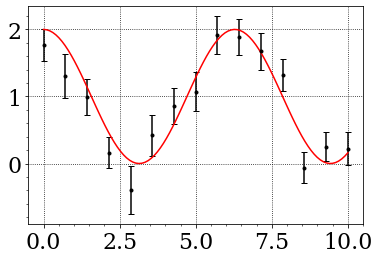

In [3]:
plt.errorbar(x=x,y=y,yerr=dy,fmt='.',label='generated noise')
plt.plot(xx,true_f(xx),label='true function')
noisy_data_dict={'x':x,'y':y,'dy':dy}
noisy_data=pd.DataFrame(data=noisy_data_dict)

In [4]:
class bayesian_fit():
    def __init__(self,data,stanfile,nsamples=1000):
        self.data=pd.DataFrame(data=data)
        self.stan_data={'n':len(self.data['x'].values),
             'x':list(self.data['x'].values),
             'y':list(self.data['y'].values),
           'dy':list(self.data['dy'].values)}
        self.stanfile=stanfile
        self.x=self.data['x']
        self.y=self.data['y']
        self.dy=self.data['dy']
        self.model = sp.CmdStanModel(stan_file=stanfile)
        self.fitobj = self.model.sample(data=self.stan_data,iter_sampling=nsamples)

    def f(self,x,a,b):
            return a*np.cos(x)+b
    def f1(self,x,a,b,c):
            return a*np.cos(x+c)+b
    def get_chisqpars(self,function):
            popt, pcov = curve_fit(function,self.data['x'].values,self.data['y'].values,
                                   sigma=self.data['dy'].values)
            return popt,pcov
    def stan_code(self):
        return self.model.code()
    def samples_df(self):
        return self.fitobj.draws_pd()
    def waic(self):
        samples=self.fitobj.draws_pd()
        pwaic=sum([np.var(samples[f'log_lik[{i+1}]'], ddof=1)for i in range(len(self.data['x']))])
        lpd=sum([np.log(np.mean(np.exp(samples[f'log_lik[{i+1}]'])))for i in range(len(self.data['x']))])
        return lpd-pwaic, pwaic, lpd
    def plot_ppd(self,samples,save,fitfunc,width=.5):
        #cosmetics
        fig, (ax, ax1)=plt.subplots(nrows=2,sharex=True,dpi=1000,gridspec_kw={'height_ratios': [4, 1]})
        ax.set_ylabel('$p(y_{rep}|y)$')
        ax.xaxis.set_ticks_position("top")
        ax.grid(which='minor',color='grey',lw='.4')
        #get results from chisq fit and plot them
        xx=np.linspace(np.min(self.data['x']),np.max(self.data['x']),200)
        yfit=fitfunc(xx,*self.get_chisqpars(fitfunc)[0])
        ax.errorbar(x=self.data['x'],y=self.data['y'],yerr=self.data['dy'],fmt='.',label='Data points')
        #ax.plot(data['x'],data['y'],'x',label='Data points')
        ax.plot(xx,yfit,'r-',label='$\chi^2$ fit',color='r')
        #violinplot for the replicated samples
        vp=ax.violinplot([samples[f'y_tilde[{i+1}]']for i in range(len(self.data['x']))],self.data['x'],showmeans=False, showextrema=False, showmedians=False,widths=width)
        #cosmetics
        for b in vp['bodies']:
            # get the center
            m = np.mean(b.get_paths()[0].vertices[:, 0])
            # modify the paths to not go further right than the center
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
            b.set_alpha(.5)
            #b.set_color('red')

        #compute p value as measure of goodness of fit
        y_arr=[samples[f'y_tilde[{i+1}]']for i in range(len(self.data['x']))]
        pvalue=[len([y for y in y_arr[i] if y>=self.data['y'][i]])/len(y_arr[i])for i in range(len(self.data['x']))]
        #plot pvalue
        #ax1.grid(which='minor',color='grey',lw='.4')
        ax1.plot(self.data['x'],pvalue,'.')
        ax1.axhline(y=0.5, color='b', linestyle='--',label='optimal value')
        ax1.set_xlabel('x')
        ax1.set_ylabel('$T(y_{rep}>y)$')
        ax1.set_ylim([0,1])
        #cosmetics and legend
        plt.subplots_adjust(wspace=0, hspace=0)
        lines,labels = ax.get_legend_handles_labels() 
        patch = mpatches.Patch(color='red', label='$y_{rep}$',alpha=.5)
        lines.append(patch)
        lines1,labels1=ax1.get_legend_handles_labels()
        lines+=lines1
        tmp=lines[0]
        lines[0]=lines[1]
        lines[1]=tmp
        plt.legend(handles=lines,bbox_to_anchor=(1,2))
        if (save==True):
            plt.savefig('plot.pdf',format='pdf',bbox_inches='tight',dpi=1000)
        def plot_posterior(self,samples,columns,save):
            return 0
            
            
        
        
  

        
        
        

In [5]:
fit=bayesian_fit(data=noisy_data_dict,stanfile='stan_file.stan')
fit1=bayesian_fit(data=noisy_data_dict,stanfile='stan_file1.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/jakob/Documents/Studium/master_thesis/bayes/stan_file
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/jakob/Documents/Studium/master_thesis/bayes/stan_file1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


In [6]:
samples=fit.samples_df()
samples1=fit1.samples_df()

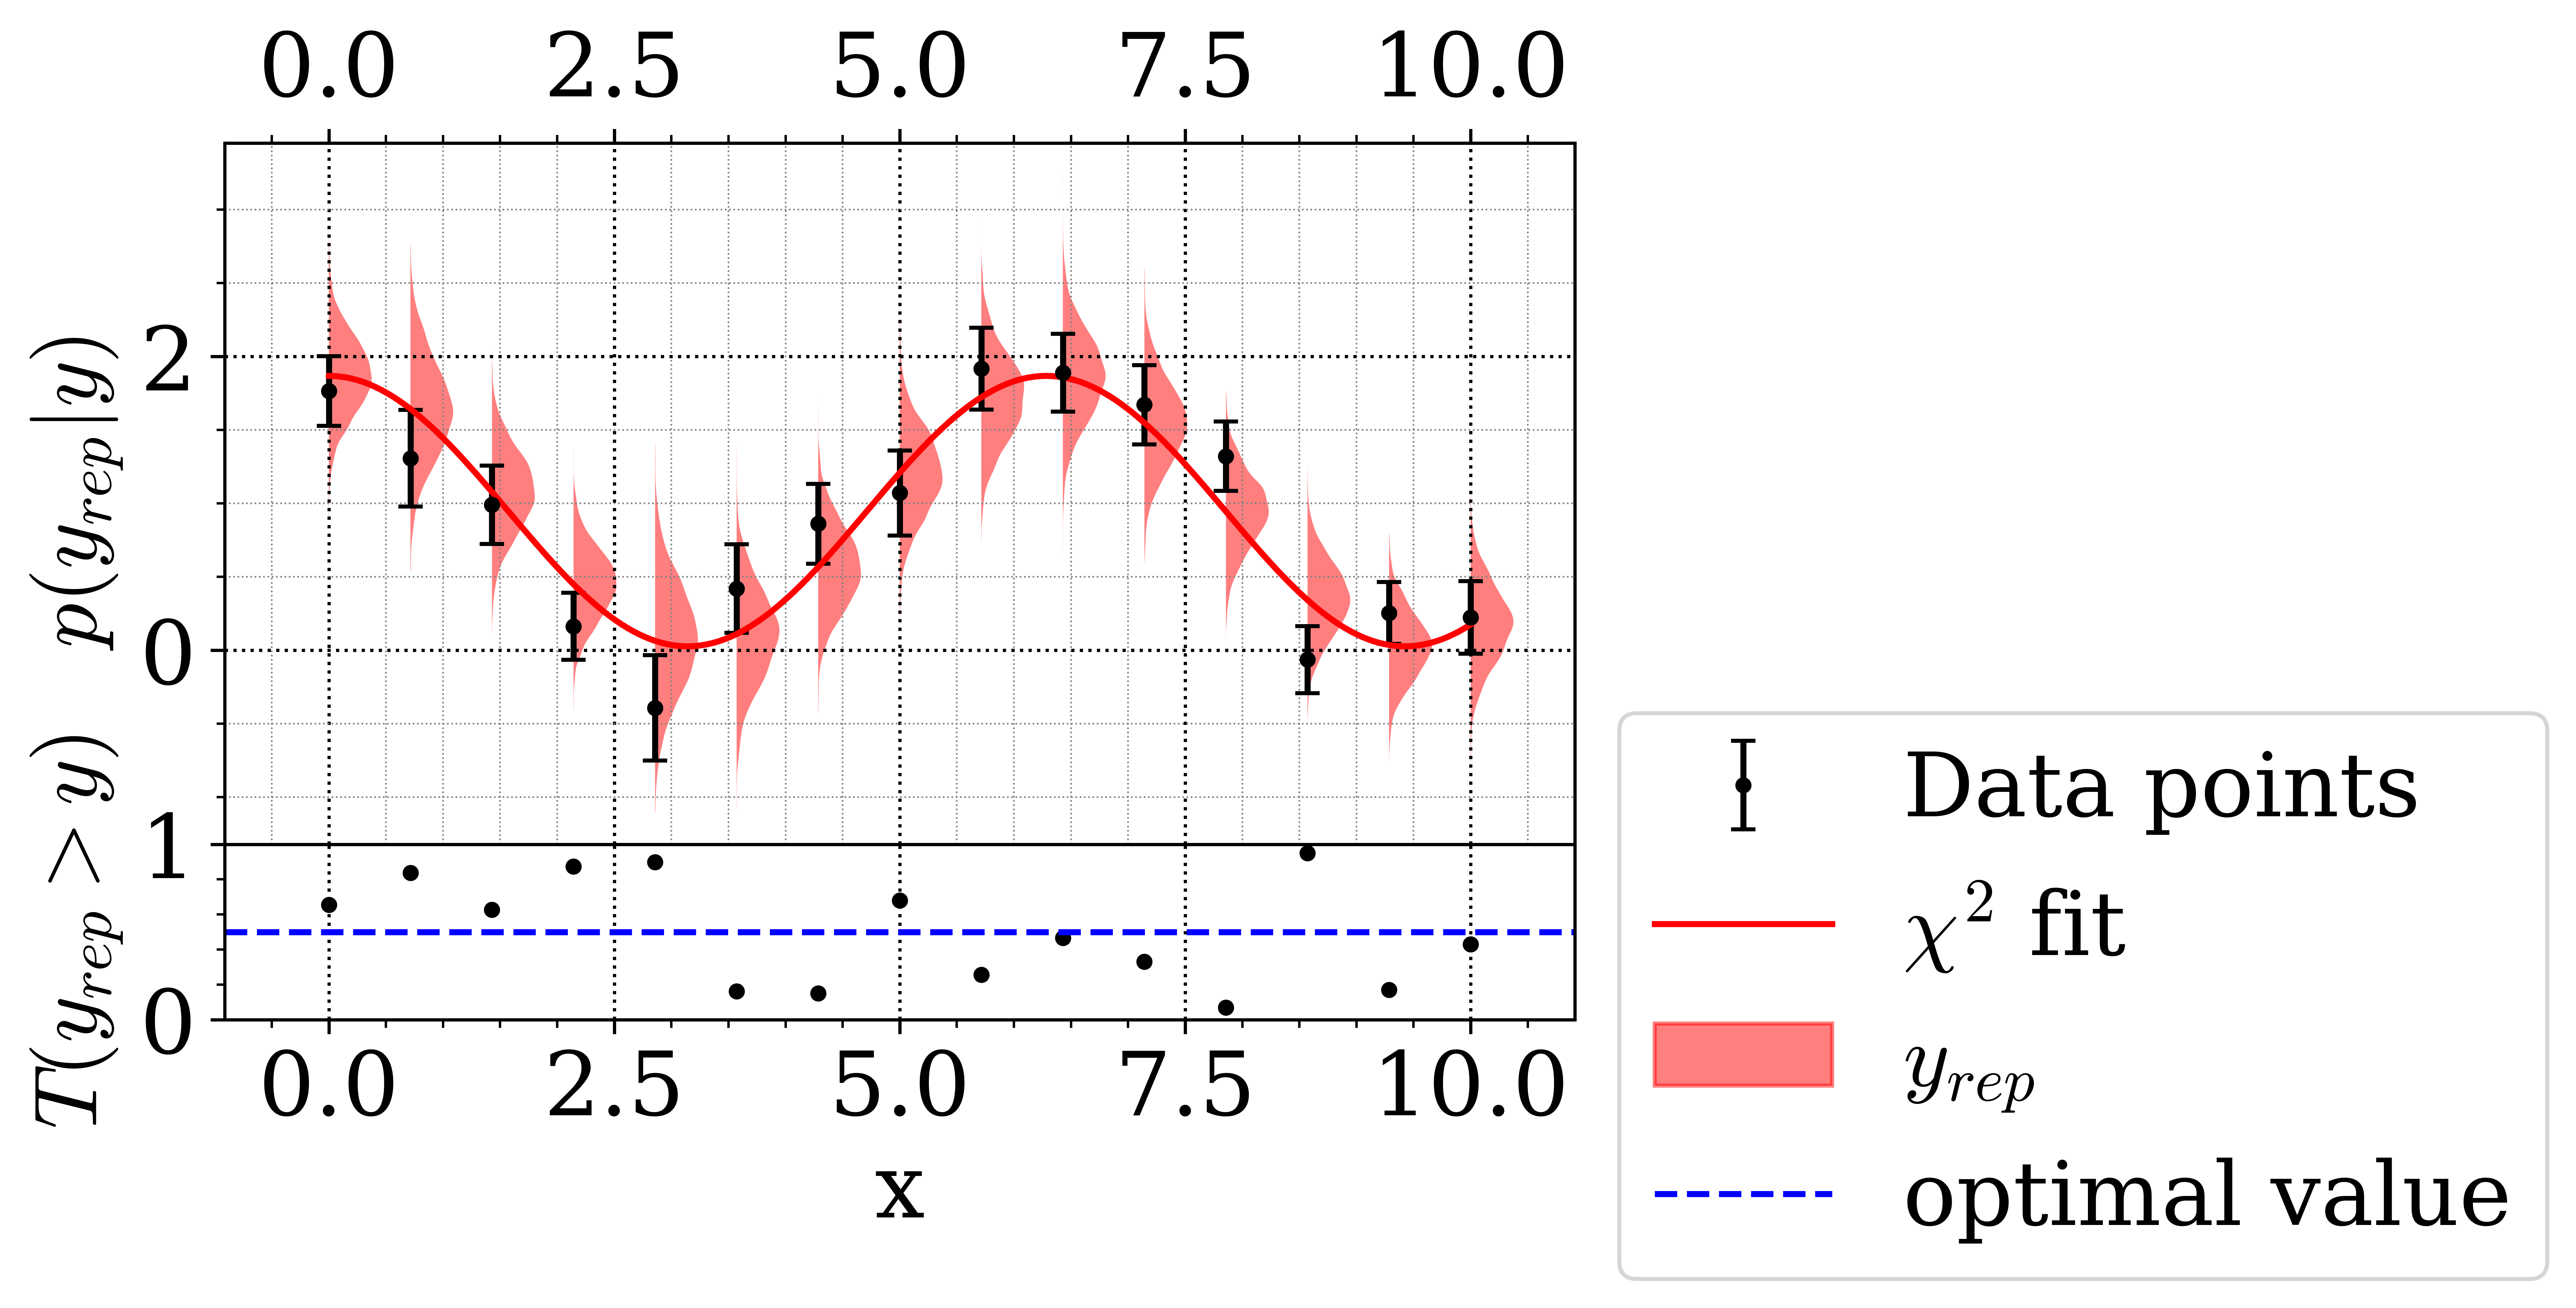

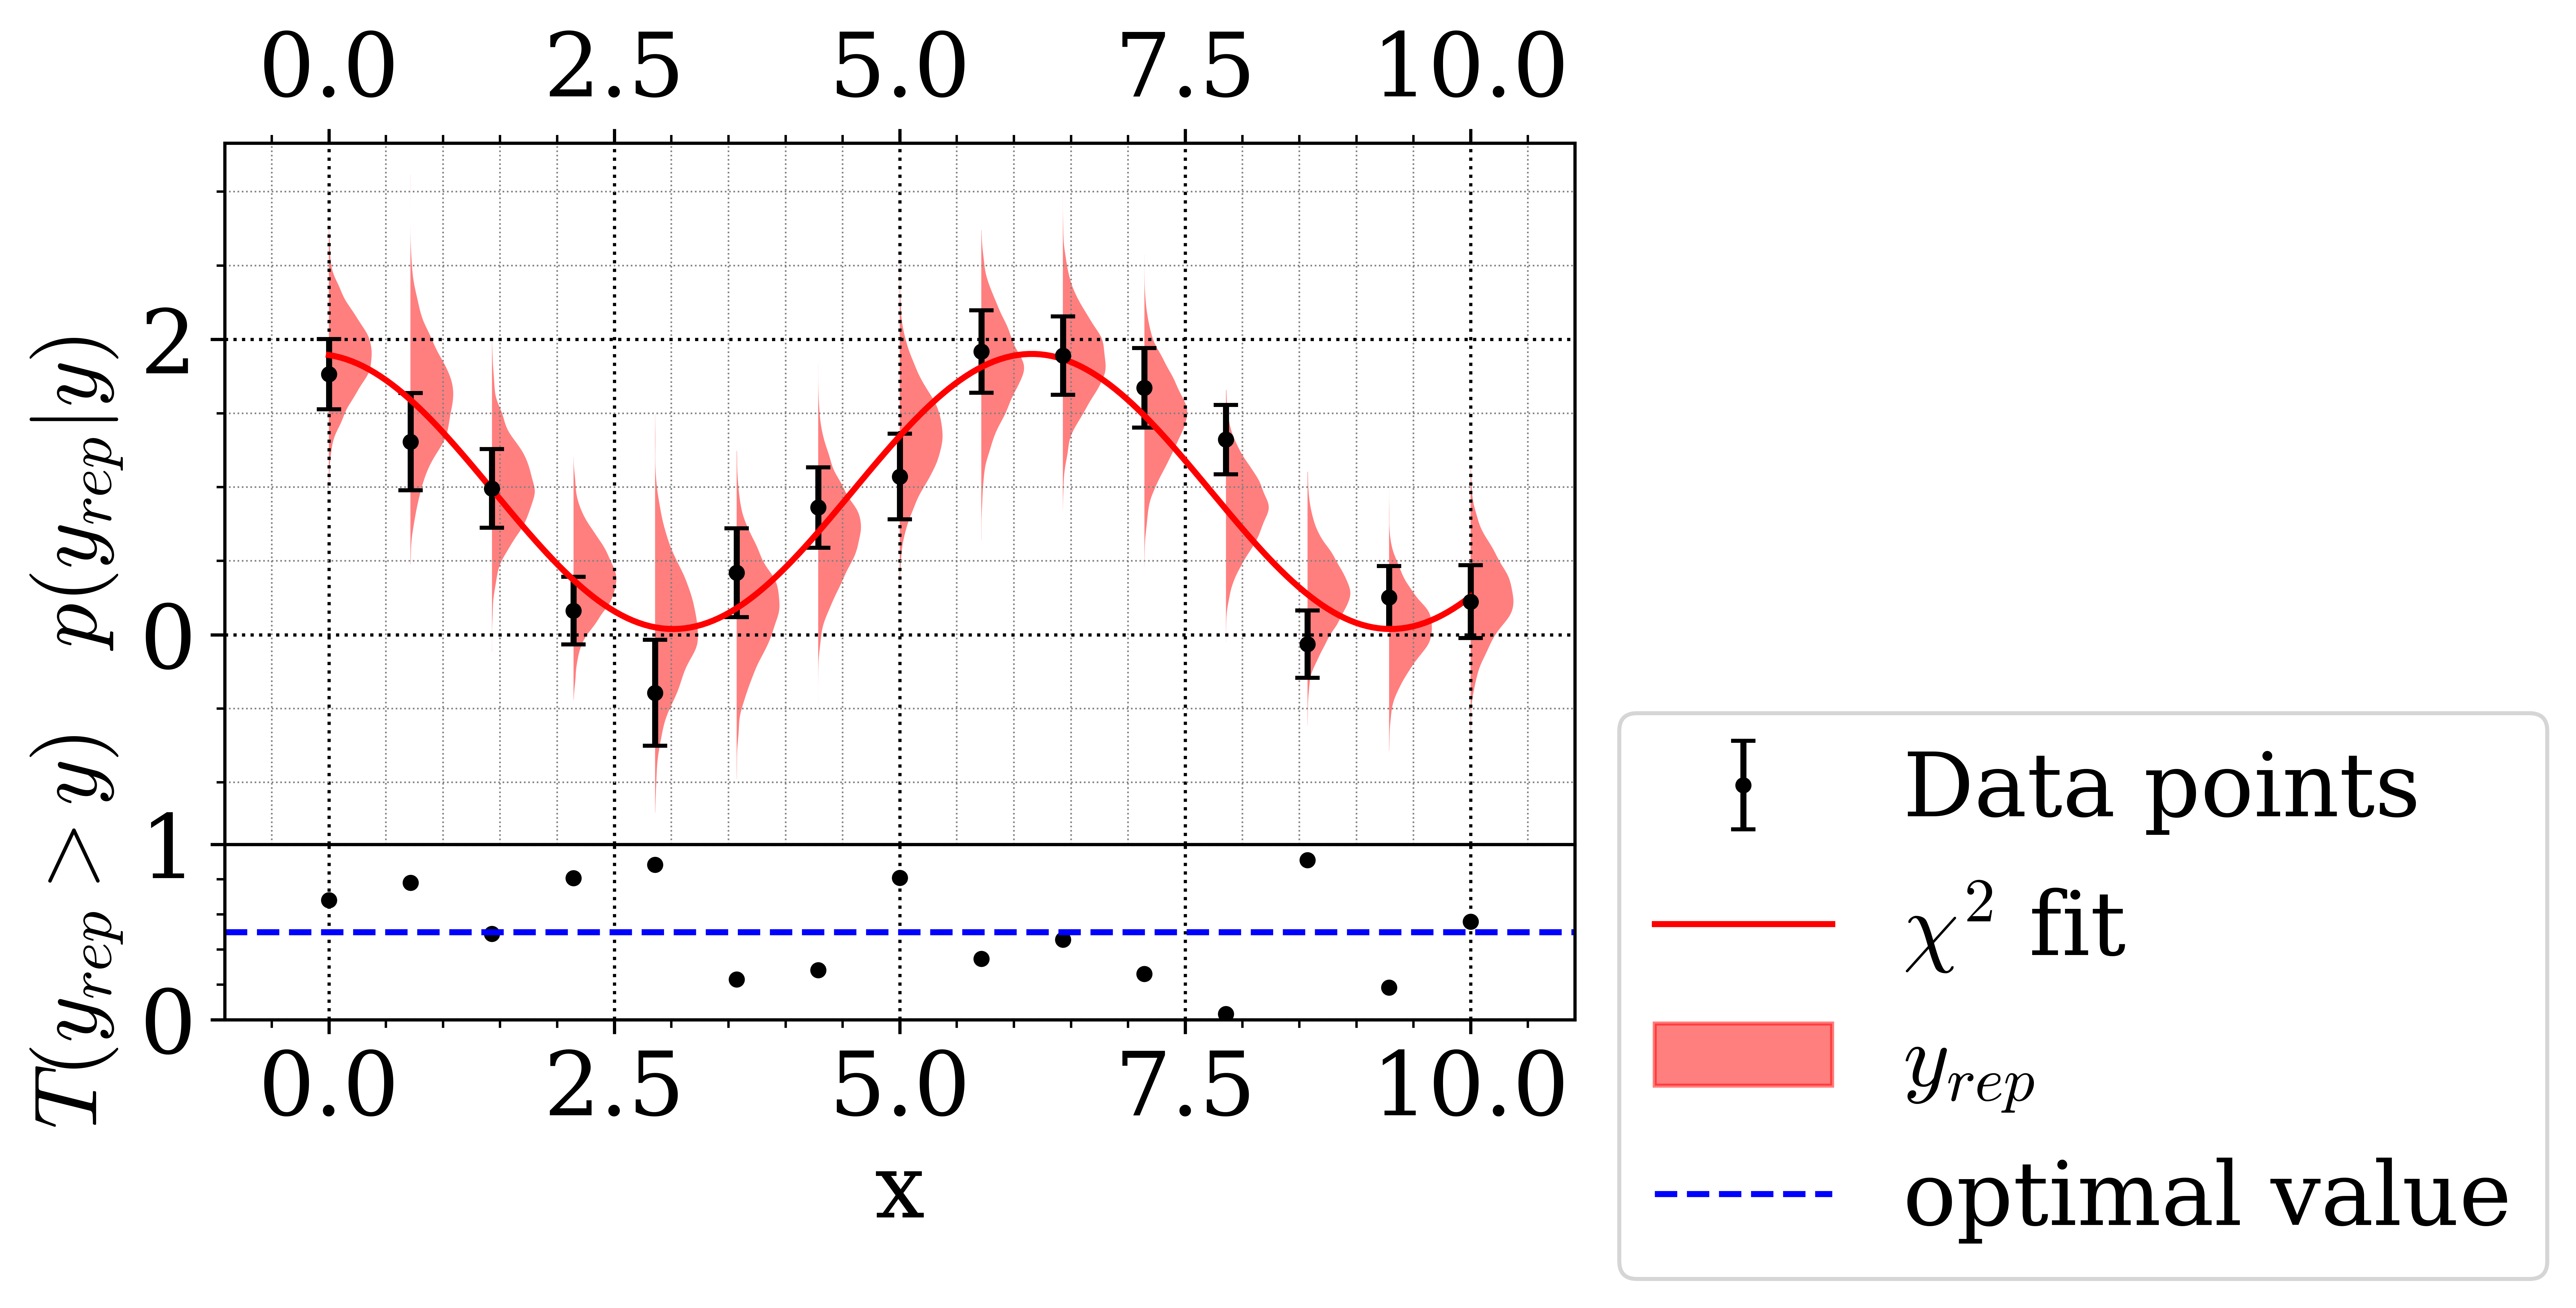

In [7]:
fit.plot_ppd(samples=samples,save=False,fitfunc=fit.f,width=.75)
fit1.plot_ppd(samples=samples1,save=False,fitfunc=fit.f1,width=.75)

In [8]:
fit.waic()

(-123.53228387758757, 30.98758607313852, -92.54469780444906)

In [9]:
fit1.waic()

(-118.44529616609185, 42.93672113174865, -75.50857503434321)

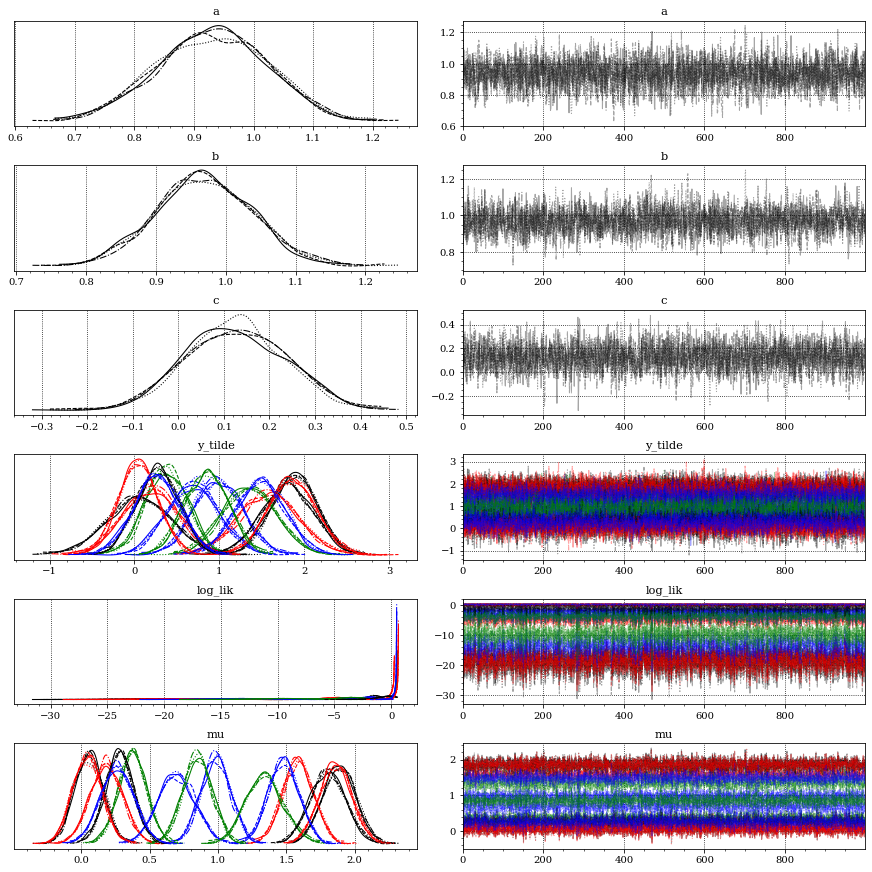

In [10]:
az.plot_trace(fit1.fitobj)
plt.show()

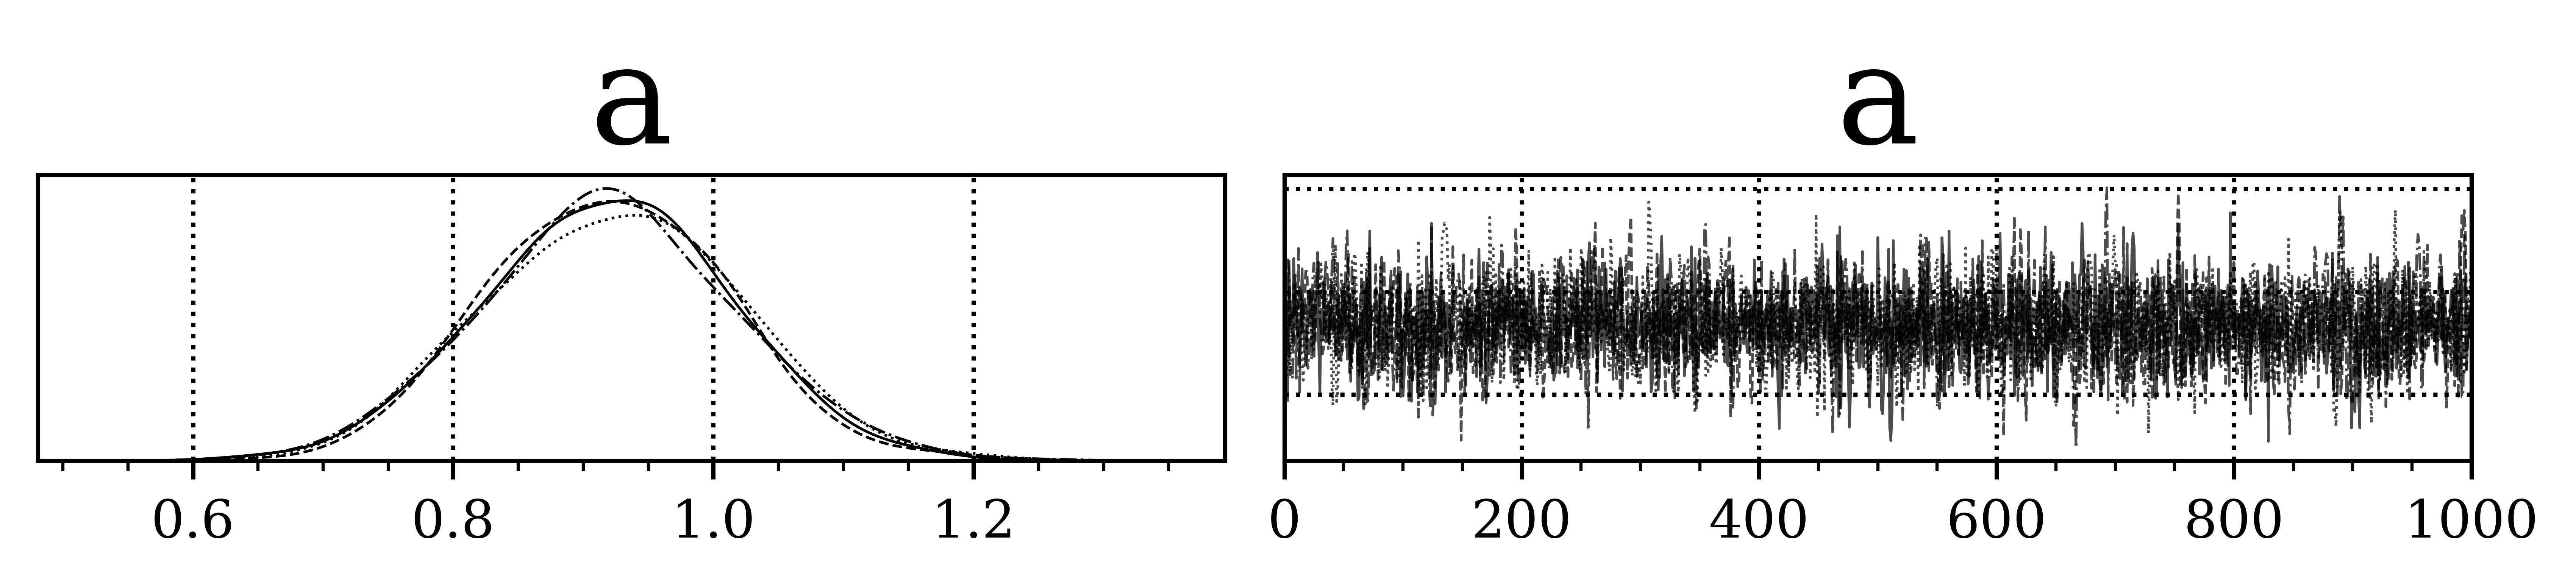

In [11]:
fig, (ax, ax1)=plt.subplots(ncols=2,dpi=1000)
ax.grid(visible=False,axis='y')
ls=['solid','dotted','dashed','dashdot']
for i in range(4):
    sns.kdeplot(samples['a'][i*1000:(i+1)*1000],ax=ax,linestyle=ls[i],color='black',linewidth=.5,bw=0.35)
    ax1.plot(np.arange(0,len(samples['a'])/4),samples['a'][i*1000:(i+1)*1000],ls=ls[i],color='black',alpha=.7,linewidth=.5)
fig.set_size_inches(8.29,1)
for ax in (ax,ax1):
    ax.tick_params(axis='y', which='both',left=False,right=False,labelleft=False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('a')
    ax.tick_params(axis='both', which='major', labelsize=10)
plt.subplots_adjust(wspace=0.05)
ax1.set_xlim([0,1000])
plt.show()

In [12]:
samples

lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0     -7.50652       0.983910    0.905422          2.0           3.0   
1     -7.58015       0.995812    0.905422          3.0           7.0   
2     -8.27625       0.923319    0.905422          2.0           3.0   
3     -9.76816       0.892392    0.905422          2.0           3.0   
4    -10.03070       0.980077    0.905422          3.0           7.0   
...        ...            ...         ...          ...           ...   
3995  -8.23469       0.762620    0.942606          2.0           3.0   
3996  -8.00857       0.990938    0.942606          2.0           7.0   
3997  -7.80785       0.970708    0.942606          2.0           3.0   
3998  -7.97764       0.808918    0.942606          2.0           7.0   
3999  -7.84450       0.924205    0.942606          2.0           3.0   

      divergent__  energy__         a         b  y_tilde[1]  ...     mu[6]  \
0             0.0   9.23711  0.874238  0.910268     1.35738  ...  0.115556   
1             0.0   7.58389  0.981383  0.983375     1.96642  ...  0.091264   
2             0.0   8.48818  0.790666  0.951266     1.72713  ...  0.232524   
3             0.0  10.28800  0.735644  0.865454     1.67243  ...  0.196728   
4             0.0  10.49100  1.075270  1.071110     2.01359  ...  0.093658   
...           ...       ...       ...       ...         ...  ...       ...   
3995          0.0  13.67970  0.829449  1.006260     1.75418  ...  0.252266   
3996          0.0   8.78994  0.810254  0.921000     1.50015  ...  0.184452   
3997          0.0   8.56279  0.890411  0.877880     1.52463  ...  0.068466   
3998          0.0   9.48089  0.889022  1.022110     2.43943  ...  0.213954   
3999          0.0   8.94733  0.983588  0.895905     2.14873  ...  0.001790   

         mu[7]    mu[8]    mu[9]   mu[10]   mu[11]    mu[12]    mu[13]  \
0     0.548468  1.15826  1.64681  1.77528  1.48087  0.907504  0.335489   
1     0.577234  1.26176  1.81018  1.95440  1.62391  0.980272  0.338152   
2     0.624052  1.17555  1.61740  1.73359  1.46732  0.948766  0.431432   
3     0.561011  1.07413  1.48523  1.59334  1.34560  0.863129  0.381795   
4     0.626118  1.37613  1.97702  2.13504  1.77293  1.067710  0.364164   
...        ...      ...      ...      ...      ...       ...       ...   
3995  0.662999  1.24155  1.70507  1.82696  1.54763  1.003640  0.460931   
3996  0.585680  1.15084  1.60363  1.72271  1.44984  0.918439  0.388288   
3997  0.509387  1.13046  1.62805  1.75890  1.45904  0.875066  0.292468   
3998  0.654188  1.27429  1.77110  1.90175  1.60236  1.019300  0.437607   
3999  0.488851  1.17491  1.72457  1.86912  1.53788  0.892796  0.249232   

        mu[14]    mu[15]  
0     0.044469  0.176720  
1     0.011466  0.159924  
2     0.168233  0.287841  
3     0.136912  0.248196  
4     0.006226  0.168886  
...        ...       ...  
3995  0.184822  0.310296  
3996  0.118568  0.241139  
3997 -0.003935  0.130762  
3998  0.141666  0.276153  
3999 -0.078187  0.070605  

[4000 rows x 54 columns]

In [13]:
samples1

lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0    -7.69632       0.995127    0.702692          3.0           7.0   
1    -7.67487       1.000000    0.702692          2.0           3.0   
2    -7.65251       0.965998    0.702692          3.0           7.0   
3    -7.94214       0.933349    0.702692          3.0           7.0   
4    -6.34106       1.000000    0.702692          2.0           3.0   
...       ...            ...         ...          ...           ...   
3995 -7.09053       0.983862    0.690776          3.0           7.0   
3996 -6.47597       0.977354    0.690776          3.0           7.0   
3997 -6.45251       0.993677    0.690776          3.0           7.0   
3998 -6.89346       0.906640    0.690776          2.0           3.0   
3999 -6.32556       1.000000    0.690776          2.0           7.0   

      divergent__  energy__         a         b         c  ...     mu[6]  \
0             0.0   9.86249  0.973194  0.988848  0.308801  ...  0.269281   
1             0.0   7.92157  0.967626  1.006610  0.310259  ...  0.292109   
2             0.0   8.87652  0.900906  0.852602  0.064393  ...  0.059503   
3             0.0  10.09630  1.087680  0.921764  0.117581  ... -0.006979   
4             0.0   7.91899  0.953335  0.953386  0.078906  ...  0.120783   
...           ...       ...       ...       ...       ...  ...       ...   
3995          0.0   7.45389  0.996070  0.954975  0.238738  ...  0.173353   
3996          0.0   7.59113  0.881578  0.986572  0.142584  ...  0.245524   
3997          0.0   6.82608  0.973558  0.939314  0.084485  ...  0.091708   
3998          0.0   7.69795  0.917292  0.899113  0.037677  ...  0.080254   
3999          0.0   6.89229  0.925134  0.970671  0.080513  ...  0.163423   

         mu[7]    mu[8]    mu[9]   mu[10]   mu[11]    mu[12]    mu[13]  \
0     0.874399  1.53547  1.92931  1.86338  1.36991  0.690149  0.156415   
1     0.894216  1.55127  1.94205  1.87551  1.38419  0.708275  0.178208   
2     0.533313  1.16322  1.64127  1.73376  1.39547  0.791788  0.217836   
3     0.590896  1.35052  1.90054  1.97206  1.53011  0.790753  0.115447   
4     0.628488  1.29503  1.79455  1.88284  1.51675  0.875237  0.271933   
...        ...      ...      ...      ...      ...       ...       ...   
3995  0.768877  1.45538  1.89725  1.87846  1.40820  0.716369  0.141189   
3996  0.739480  1.35423  1.78925  1.83185  1.46122  0.858541  0.318457   
3997  0.612636  1.29327  1.80086  1.88726  1.51023  0.854094  0.239617   
3998  0.551220  1.19226  1.68999  1.80108  1.47121  0.861664  0.270421   
3999  0.656782  1.30359  1.78765  1.87230  1.51617  0.893351  0.308336   

        mu[14]    mu[15]  
0     0.029640  0.371799  
1     0.053127  0.394181  
2    -0.045794  0.129782  
3    -0.165669  0.084836  
4     0.001776  0.196839  
...        ...       ...  
3995 -0.036151  0.271049  
3996  0.105000  0.322523  
3997 -0.032794  0.170036  
3998 -0.013468  0.148783  
3999  0.047122  0.237409  

[4000 rows x 55 columns]